In [1]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import h3
import h3pandas
from joblib import Parallel, delayed
import json
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
COLS_TO_DROP = ['bbox_north', 'bbox_south', 'bbox_east', 'bbox_west',
       'place_id', 'osm_type', 'osm_id', 'lat', 'lon', 'class', 'type',
       'place_rank', 'importance', 'addresstype', 'name', 'display_name']
HEX_RESOLUTION = 8

In [3]:
amsterdam_bike_paths = gpd.read_parquet("amsterdam_bike_paths_extended.parquet")

In [5]:
amsterdam_bike_paths.head(1)

,id,tags,geometry
0,4264947,"{'abandoned:railway': None, 'access': None, 'a...","LINESTRING (4.92236 52.36544, 4.92237 52.36543..."


<AxesSubplot: >

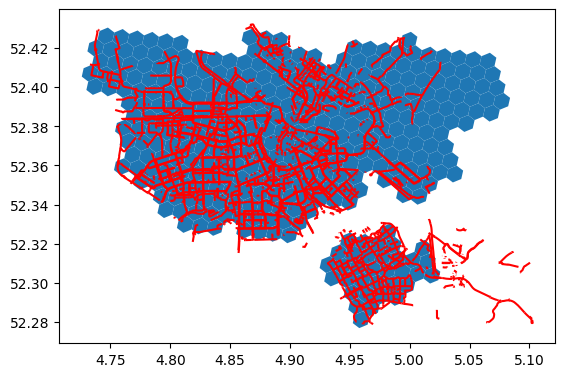

In [11]:
amsterdam_gdf = ox.geocode_to_gdf({'city': 'Amsterdam'})
fig, ax = plt.subplots(1,1)
amsterdam_gdf.h3.polyfill_resample(HEX_RESOLUTION).plot(ax=ax)
amsterdam_bike_paths.plot(ax=ax, color="red")

In [12]:
COLS_TO_DROP = ['bbox_north', 'bbox_south', 'bbox_east', 'bbox_west',
       'place_id', 'osm_type', 'osm_id', 'lat', 'lon', 'class', 'type',
       'place_rank', 'importance', 'addresstype', 'name', 'display_name']
HEX_RESOLUTION = 8

In [13]:
amsterdam_gdf = ox.geocode_to_gdf({'city': 'Amsterdam'})
polygons = amsterdam_gdf.h3.polyfill_resample(HEX_RESOLUTION)
polygons = polygons.drop(COLS_TO_DROP, axis=1)

# amsterdam_gdf = amsterdam_gdf.to_crs(28992)
# polygons = polygons.to_crs(28992)

<AxesSubplot: >

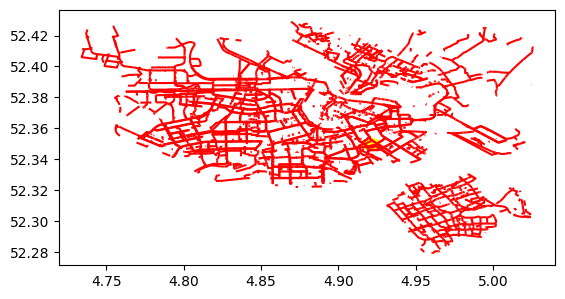

In [69]:
fig, ax = plt.subplots(1,1)
gpd.clip(amsterdam_bike_paths, polygons).plot(ax=ax, color="red", zorder=3)
gpd.GeoSeries([polygons.iloc[175]["geometry"]]).plot(ax=ax, zorder=1, color="yellow")

In [12]:
stop

NameError: name 'stop' is not defined

In [ ]:
# way - line
# node - point

<AxesSubplot: >

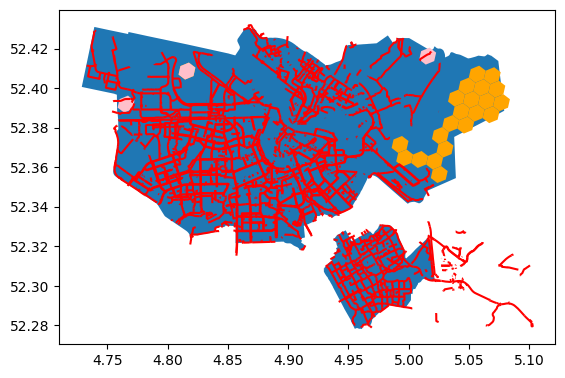

In [102]:
amsterdam_gdf = ox.geocode_to_gdf({'city': 'Amsterdam'})
fig, ax = plt.subplots(1,1)
amsterdam_gdf.plot(ax=ax)
amsterdam_bike_paths.plot(ax=ax, color="red")
polygons[polygons["green_area_abs"]==0]["geometry"].plot(ax=ax, color="orange")
polygons[polygons["num_buildings"]==15]["geometry"].plot(ax=ax, color="pink")

In [356]:
with open('config/amt_columns_binning_config.json') as json_config:
    AMT_VARS_DICT = json.load(json_config)
    
with open("config/area_columns_binning_config.json") as json_config:
    AREA_VARS_DICT = json.load(json_config)
    
with open("config/len_columns_binning_config.json") as json_config:
    LEN_VARS_DICT = json.load(json_config)

In [354]:
# AMT_VARS_DICT = {  
# "bicycle_related_amenities": {"amenity": ["bicycle_parking",
# "bicycle_rental",
# "bicycle_repair_station",]
# },
# "academia_related_amenities": {"amenity": ["college",
# "library",
# "university",
# ],
# },
# "public_services_amenities": {"amenity": ["police", "fire_station", "hospital", "post_office", "bank"]},
# "leisure_and_entertainment_amenities": {"amenity": ["restaurant", "cinema",]},
# "parkings": {"amenity": ["parking",]},
# "schools": {"amenity": ["school"],},
# "atms": {"amenity": ["atm"],},
# "fountains": {"amenity": ["fountain"],},
# "benches": {"amenity": ["bench"],},
# "camping_related_objects": {"tourism": ["camp_site", "camp_pitch"]},
# "tourism_related_objects": {"tourism": ["attraction",
# "hotel", 
# "hostel",
# "museum",
# ]},
# "picnic_sites": {"tourism": ["picnic_site"]},
# "viewpoints": {"tourism": ["viewpoint"]},

# "crossings": {"highway": ["crossing"]},
# "traffic_signals": {"highway": ["traffic_signals"]},
    
# "buildings": {'building': ['yes']},
# }

# AREA_VARS_DICT = {
#     "green_space": {'landuse': ['forest', 'grass', 'meadow', 'recreation_ground'], 'leisure': 'park'},
#     "buildings": {'building': ['yes']},
#     "water_bodies": {'natural': ['water']}
# }

# LEN_VARS_DICT = {
#     "primary_roads": {"highway": ["primary"]},
#     "secondary_roads": {"highway": ["secondary"]},
#     "residential_roads": {"highway": ["residential"]},
#     "unclassified_roads": {"highway": ["unclassified"]},
#     "pedestrian_roads": {"highway": ["pedestrian"]},
# }

# with open("config/amt_columns_binning_config.json", "w") as outfile:
#     json.dump(AMT_VARS_DICT, outfile, indent=4, sort_keys=False)
    
# with open("config/area_columns_binning_config.json", "w") as outfile:
#     json.dump(AREA_VARS_DICT, outfile, indent=4, sort_keys=False)
    
# with open("config/len_columns_binning_config.json", "w") as outfile:
#     json.dump(LEN_VARS_DICT, outfile, indent=4, sort_keys=False)

In [158]:
def calculate_tag_area(geometry, tags_dict):
    try:
        features = ox.features.features_from_polygon(
            geometry, 
            tags=tags_dict
        )["geometry"]
        features = features.clip(geometry)    
    except Exception as e:
        print(e)
        return 0
    return features.to_crs(28992).area.sum()

def calculate_tag_amt(geometry, tags_dict):
    try:
        features = ox.features.features_from_polygon(geometry, tags=tags_dict)
    except Exception as e:
        print(e) # logger
        return 0
    return features.shape[0]

def calculate_tag_len(geometry, tags_dict):
    try:
        features = ox.features.features_from_polygon(
            geometry, 
            tags=tags_dict
        )["geometry"]
        features = features.clip(geometry) 
    except Exception as e:
        print(e) # logger
        return 0
    return features.to_crs(28992).length.sum()

def get_bike_paths_len(geometry, bike_paths):
    clipped = gpd.clip(bike_paths, geometry)
    return clipped.to_crs(28992).length.sum()

In [187]:
for tag_key, tags_dict in AMT_VARS_DICT.items():
    polygons[f"{tag_key}_amt"] = Parallel(n_jobs=-1)(delayed(calculate_tag_amt)(polygon, tags_dict) for polygon in polygons["geometry"])
    
for tag_key, tags_dict in AREA_VARS_DICT.items():
    polygons[f"{tag_key}_area"] = Parallel(n_jobs=-1)(delayed(calculate_tag_area)(polygon, tags_dict) for polygon in polygons["geometry"])
    
for tag_key, tags_dict in LEN_VARS_DICT.items():
    polygons[f"{tag_key}_len"] = Parallel(n_jobs=-1)(delayed(calculate_tag_len)(polygon, tags_dict) for polygon in polygons["geometry"])
    
polygons["bike_paths_len"] = Parallel(n_jobs=-1)(delayed(get_bike_paths_len)(polygon, amsterdam_bike_paths) for polygon in polygons["geometry"])

In [186]:
polygons.columns

Index(['index', 'geometry', 'bicycle_wash_amt', 'bicycle_parking_amt',
       'bicycle_rental_amt', 'bicycle_repair_station_amt', 'college_amt',
       'library_amt', 'school_amt', 'university_amt', 'attraction_amt',
       'camp_site_amt', 'camp_pitch_amt', 'hotel_amt', 'hostel_amt',
       'motel_amt', 'viewpoint_amt', 'museum_amt', 'accom', 'tourist',
       'picnic_site_amt', 'parking_amt', 'restaurant_amt', 'atm_amt',
       'bank_amt', 'hospital_amt', 'cinema_amt', 'fountain_amt',
       'fire_station_amt', 'police_amt', 'post_office_amt', 'bench_amt',
       'grave_yard_amt', 'marketplace_amt', 'pike_paths_len',
       'primary_roads_len', 'secondary_roads_len', 'residential_roads_len',
       'unclassified_roads_len', 'pedestrian_roads_len', 'sidewalks_len'],
      dtype='object')

In [303]:
# import mlflow
# # mlflow.set_tracking_uri("http://localhost:5000")
# mlflow.start_run()
# mlflow.set_experiment("your_experiment_name")

In [305]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X =  polygons[['bicycle_wash_amt', 'bicycle_parking_amt',
       'bicycle_rental_amt', 'bicycle_repair_station_amt', 'college_amt',
       'library_amt', 'school_amt', 'university_amt', 'attraction_amt',
       'camp_site_amt', 'camp_pitch_amt', 'hotel_amt', 'hostel_amt',
       'motel_amt', 'viewpoint_amt', 'museum_amt', 'accom', 'tourist',
       'picnic_site_amt', 'parking_amt', 'restaurant_amt', 'atm_amt',
       'bank_amt', 'hospital_amt', 'cinema_amt', 'fountain_amt',
       'fire_station_amt', 'police_amt', 'post_office_amt', 'bench_amt',
       'grave_yard_amt', 'marketplace_amt',
       'primary_roads_len', 'secondary_roads_len', 'residential_roads_len',
       'unclassified_roads_len', 'pedestrian_roads_len', 'sidewalks_len']]

y = polygons["bike_paths_len"]

X_temp, X_holdout, y_temp, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

def forward_feature_selection(X_train, y_train, X_test, y_test):
    initial_features = []
    remaining_features = list(X_train.columns)
    best_features = []
    best_score = float('inf')
    
    for n in range(20):
        scores_with_candidates = []
        for candidate in remaining_features:
            features = initial_features + [candidate]
            model = LinearRegression()
            model.fit(X_train[features], y_train)
            y_pred = model.predict(X_test[features])
            score = mean_squared_error(y_test, y_pred)
            scores_with_candidates.append((score, candidate))
        
        scores_with_candidates.sort()
        best_score, best_candidate = scores_with_candidates[0]
        
        initial_features.append(best_candidate)
        remaining_features.remove(best_candidate)
        best_features.append(best_candidate)
        
        print(f'Added {best_candidate} with score {best_score}')
    
    return best_features

best_features = forward_feature_selection(X_train, y_train, X_test, y_test)
print("Best features:", best_features)

Added secondary_roads_len with score 2267972.0966024823
Added primary_roads_len with score 1620077.6733710575
Added residential_roads_len with score 1307771.8865099475
Added hospital_amt with score 1234722.0735159821
Added bench_amt with score 1171149.945324296
Added picnic_site_amt with score 1136847.7090880834
Added hostel_amt with score 1117114.997418735
Added atm_amt with score 1094449.2153470383
Added bicycle_repair_station_amt with score 1089379.3434618711
Added accom with score 1081499.2326918028
Added fire_station_amt with score 1076524.0975748717
Added pedestrian_roads_len with score 1073237.033718495
Added bicycle_wash_amt with score 1073237.033718495
Added camp_pitch_amt with score 1073237.033718495
Added motel_amt with score 1073237.033718495
Added sidewalks_len with score 1073237.033718495
Added hotel_amt with score 1073237.0337185103
Added bank_amt with score 1073316.208979929
Added fountain_amt with score 1073840.3972830693
Added grave_yard_amt with score 1074844.7644706

In [342]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

features = ['secondary_roads_len', 'primary_roads_len', 'residential_roads_len', 'hospital_amt', 'bench_amt',
            'picnic_site_amt','hostel_amt', 'atm_amt', 'bicycle_repair_station_amt']
model = LinearRegression()

model.fit(pd.concat([X_train[features], X_test[features]]), pd.concat([y_train, y_test]))

y_holdout_pred = model.predict(X_holdout[features])

mse = mean_squared_error(y_holdout, y_holdout_pred)
r2 = r2_score(y_holdout, y_holdout_pred)
mae = mean_absolute_error(y_holdout, y_holdout_pred)

scores = mse, r2, mae
print(scores) 

(1399409.629547565, 0.524268094891857, 997.963872728454)


In [321]:
y.mean(), y.max()

(2318.4848623313733, 7898.820945335925)

Roznice miedzy hexami a mapa Amsterdamu

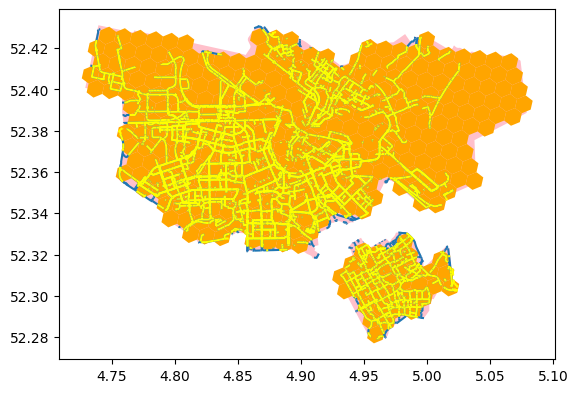

In [261]:
fig, ax = plt.subplots(1,1)
amsterdam_gdf.plot(ax=ax, color="pink")
polygons["geometry"].plot(ax=ax, color="orange")
clipped.plot(ax=ax)
# gpd.GeoSeries(temp).plot(ax=ax, color="red")
for i in range(0,352):
    # if len(polygon)>0:
    g = gpd.clip(amsterdam_bike_paths, polygons["geometry"].iloc[i])
    # print(len(g))
    if len(g)>0:
        g.plot(ax=ax, color="yellow")